In [17]:
# %pip install torchao tqdm torchmetrics torch torchvision --index-url https://download.pytorch.org/whl/cu126
# %pip install matplotlib torchinfo
# %reset

In [18]:
# %pip uninstall -y torch torchvision torchinfo tqdm torchmetrics torchao

In [ ]:
import torch
from torchvision import transforms
from torchvision.models import mobilenet_v3_large
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

device = 'cuda'
model = torch.load("./model.pt", weights_only=False)
# model = mobilenet_v3_large(num_classes=10).to(device).to(torch.float32)
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
from tqdm import tqdm
from torchmetrics import Accuracy

def train(model, device):
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    acc_metric = Accuracy("multiclass", num_classes=10).to(device)
    num_epochs = 100
    
    
    for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Epochs", disable=True):
        model.train()
        epoch_preds = []
        epoch_labels = []
        for batch in tqdm(train_loader, total=len(train_loader)):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_preds.append(outputs)
            epoch_labels.append(labels) 
        epoch_preds = torch.cat(epoch_preds)
        epoch_labels = torch.cat(epoch_labels)
        train_acc = acc_metric(epoch_preds, epoch_labels)
        if (epoch+1)%10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_acc:.4f}")

    print("Training complete.")
    
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train(model, device)

100%|██████████| 1563/1563 [01:11<00:00, 21.93it/s]


Epoch [10/100], Loss: 2.0827, Training Accuracy: 0.4756


100%|██████████| 1563/1563 [01:11<00:00, 21.86it/s]


Epoch [20/100], Loss: 1.9501, Training Accuracy: 0.4706


100%|██████████| 1563/1563 [01:11<00:00, 21.93it/s]


Epoch [30/100], Loss: 0.9890, Training Accuracy: 0.5185


100%|██████████| 1563/1563 [01:22<00:00, 18.94it/s]


Epoch [40/100], Loss: 1.1335, Training Accuracy: 0.5477


100%|██████████| 1563/1563 [02:39<00:00,  9.81it/s]


Epoch [50/100], Loss: 1.6214, Training Accuracy: 0.5880


100%|██████████| 1563/1563 [02:43<00:00,  9.58it/s]


Epoch [60/100], Loss: 1.1496, Training Accuracy: 0.5814


100%|██████████| 1563/1563 [02:39<00:00,  9.79it/s]


Epoch [70/100], Loss: 1.7172, Training Accuracy: 0.5890


100%|██████████| 1563/1563 [02:38<00:00,  9.83it/s]


Epoch [80/100], Loss: 1.1525, Training Accuracy: 0.6126


100%|██████████| 1563/1563 [02:41<00:00,  9.66it/s]


Epoch [90/100], Loss: 2.2200, Training Accuracy: 0.5871


100%|██████████| 1563/1563 [02:39<00:00,  9.82it/s]


Epoch [100/100], Loss: 0.9665, Training Accuracy: 0.6351
Training complete.


In [30]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0

for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_b = (param_size + buffer_size)
print('model size: {:.0f}B'.format(size_all_b))
from torch.utils.flop_counter import FlopCounterMode
from typing import Union, Tuple
def get_flops(model, inp: Union[torch.Tensor, Tuple], with_backward=False):
    istrain = model.training
    model.eval()
    
    inp = inp if isinstance(inp, torch.Tensor) else torch.randn(inp)
    inp = inp.to(device)
    flop_counter = FlopCounterMode(display=False, depth=None)
    with flop_counter:
        if with_backward:
            model(inp).sum().backward()
        else:
            model(inp)
    total_flops =  flop_counter.get_total_flops()
    if istrain:
        model.train()
    return total_flops
flops = get_flops(model, (1, 3, 28, 28))
print(f"Total FLOPs for a single forward pass: {flops:,}")

model size: 16957336B
Total FLOPs for a single forward pass: 13,713,040


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ## forward ##         5.48%      31.942ms        55.69%     324.672ms      64.934ms           0 B      -5.72 MB             5  
                                            aten::randn         0.06%     349.637us         1.29%       7.493ms       1.499ms       5.72 MB           0 B             5  
                                            aten::empty         2.63%      15.348ms         2.75%      16.007ms       5.658us       5.72 MB       5.72

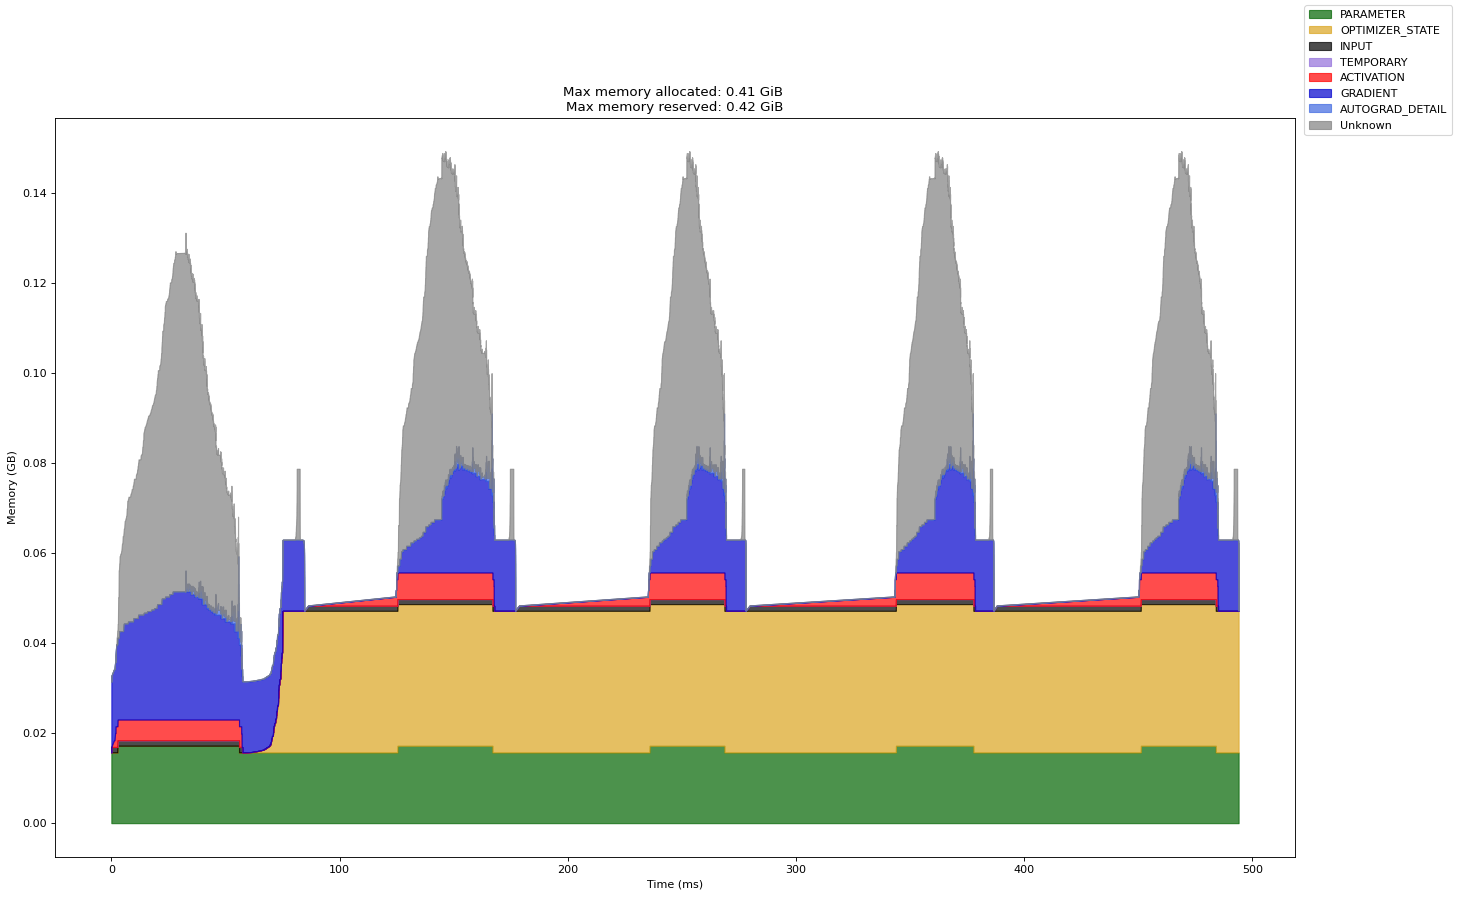

In [31]:
import torch.profiler
from torch.profiler import ProfilerActivity
from torch.autograd.profiler import record_function

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()
model.to(device)
with torch.profiler.profile(
    activities=[ProfilerActivity.CPU], 
    profile_memory=True, 
    record_shapes=True, 
    with_stack=True
    ) as prof:
   
    for _ in range(5):
        prof.step()
        with record_function("## forward ##"):
            output = model(torch.randn((10, 3, 100, 100)).to(device))
        
        with record_function("## backward ##"):
            loss = output.sum()
            loss.backward()
        
        with record_function("## optimizer step ##"):
            optimizer.step()
            optimizer.zero_grad()

print(prof.key_averages().table(row_limit=10))
prof.export_memory_timeline(f"profiler_output_static.html", device='cuda:0')


In [32]:
from torchao.quantization import Int8WeightOnlyConfig, quantize_
import copy
model_q = copy.deepcopy(model)
quantize_(model_q, Int8WeightOnlyConfig())
import os
torch.save(model_q, "./model_q.pt")
torch.save(model, "./model.pt")
model_q_size_mb = os.path.getsize("/tmp/model_q.pt") / 1024 / 1024
model_size_mb = os.path.getsize("/tmp/model.pt") / 1024 / 1024

print("int8 model size: %.2f MB" % model_q_size_mb)

print("float16 model size: %.2f MB" % model_size_mb)


int8 model size: 12.78 MB
float16 model size: 16.30 MB


In [33]:
param_size = 0
for param in model_q.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0

for buffer in model_q.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_b = (param_size + buffer_size)
print('model size: {:.0f}B'.format(size_all_b))
from torch.utils.flop_counter import FlopCounterMode
from typing import Union, Tuple
def get_flops(model_q, inp: Union[torch.Tensor, Tuple], with_backward=False):
    istrain = model_q.training
    model_q.eval()
    
    inp = inp if isinstance(inp, torch.Tensor) else torch.randn(inp)
    inp = inp.to("cuda" if torch.cuda.is_available() else "cpu")
    flop_counter = FlopCounterMode(display=False, depth=None)
    with flop_counter:
        if with_backward:
            model_q(inp).sum().backward()
        else:
            model_q(inp)
    total_flops =  flop_counter.get_total_flops()
    if istrain:
        model_q.train()
    return total_flops
flops = get_flops(model_q, (1, 3, 28, 28))
print(f"Total FLOPs for a single forward pass: {flops:,}")

model size: 16957336B
Total FLOPs for a single forward pass: 13,713,040


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         2.36%      14.975ms         2.52%      16.022ms       5.628us       0.000us         0.00%       0.000us       0.000us       5.72 MB       5.72 MB     503.02 MB     503.02 M

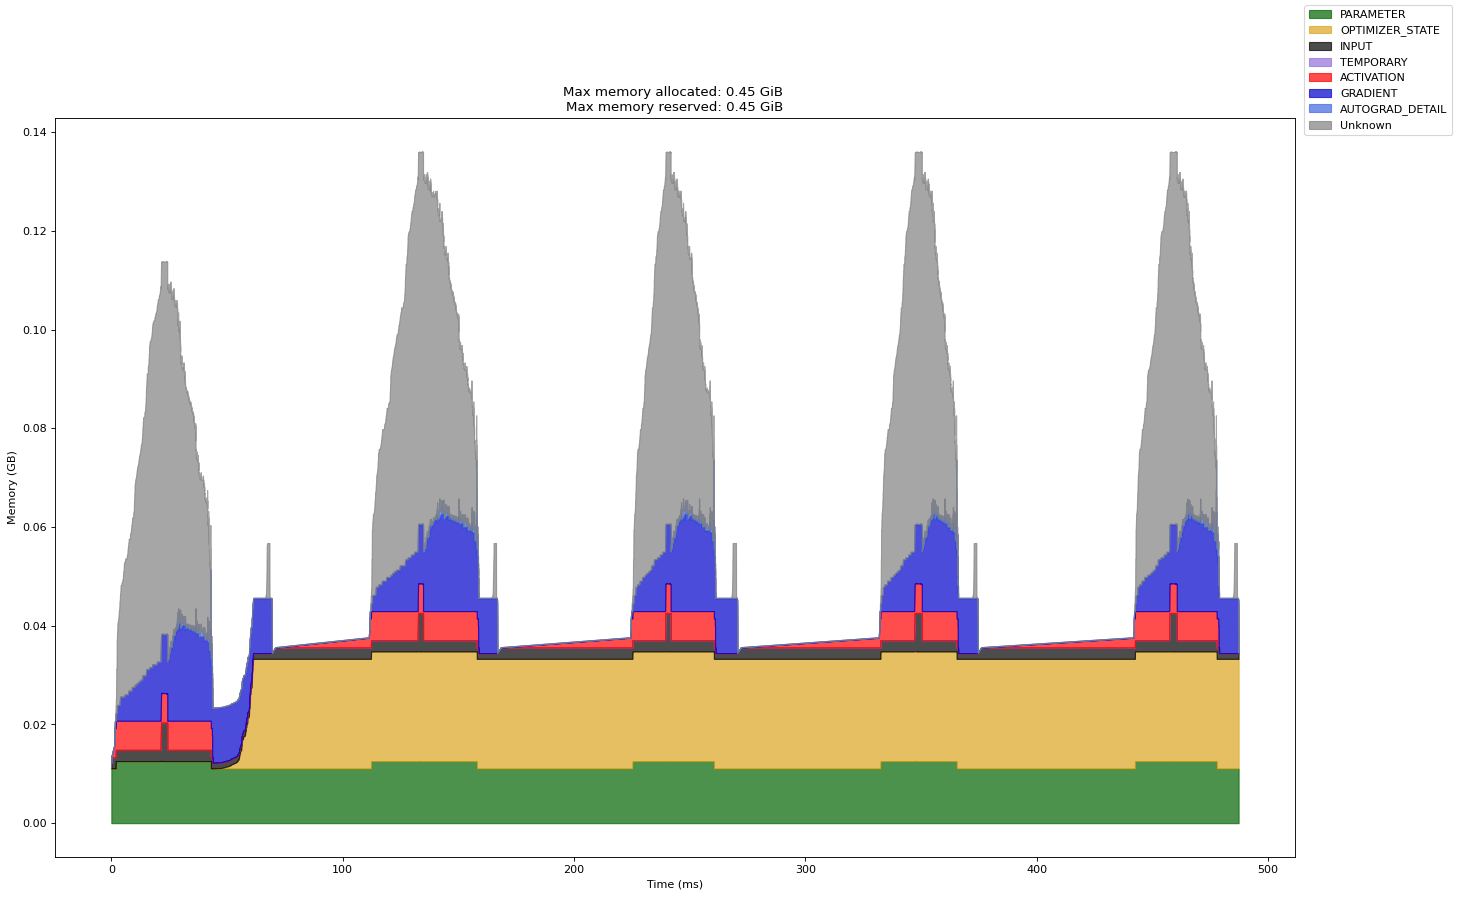

In [34]:
optimizer = torch.optim.Adam(model_q.parameters(), lr=0.001)
model_q.train()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_q.to(device)
with torch.profiler.profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], 
    profile_memory=True, 
    record_shapes=True, 
    with_stack=True
    ) as prof:
   
    for _ in range(5):
        prof.step()
        with record_function("## forward ##"):
            output = model_q(torch.randn((10, 3, 100, 100)).to(device))
        
        with record_function("## backward ##"):
            loss = output.sum()
            loss.backward()
        
        with record_function("## optimizer step ##"):
            optimizer.step()
            optimizer.zero_grad()

print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))
prof.export_memory_timeline(f"profiler_output_static_q.html", device='cuda:0')